# N-gram Lanuage Models

Our goal is to build a machine that assigns probabilities to words or sequences of words. We call such machine *language model*. 

The probability model is over the set of all finite sequences over a given vocabulary (aka alphabet) $\mathcal W$, which is countable. 



A simple class of language models are N-gram model, in which we make the assumption:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i | w_{i-N+1},\ldots,w_{i-1}] = \prod_{i=1}^n \Pr[w_i | w^{i-1}_{i-N+1}] 
$$
where:
$$ 
w^{m+p}_{m} := \begin{cases} (w_m,\ldots,w_{m+p}) & m \geq 1, \\
\emptyset & m=0,
\end{cases}
$$
for $m,p \in \mathbb N$. 


For example, with $N=2$ we have:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] =  \Pr[w_1]\prod_{i=2}^n \Pr[w_i | w_{i-1}] 
$$


In [241]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

## Building N-gram models

### Large Movie Review Dataset
From https://ai.stanford.edu/~amaas/data/sentiment/: This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

(direct link https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

Here we use this dataset arranged in a .csv file as an be found at https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download


Read dataset file. Each row is a review. 

In [242]:
df = pd.read_csv("../Data/IMDB reviews.csv")
print(df.describe())
print(df.head())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  negative
freq                                                    5     25000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


####  Add sentence start and end symbols:

In [243]:
import re

SENT_START_TOKEN = '<s>'
SENT_END_TOKEN = '</s>'

def break_sentence(text: str, sep=r'\.|\n') -> str:
    """
    Add SENT_START_TOKEN and SENT_END_TOKEN at the beginning and
    ending of every sentence. 
    
    Args:
        :text: is a text input
        :sep: explains how to identify sentnce ending (regular expression)
    """
    sentences = re.split(sep, text)
    sent_break = f' {SENT_END_TOKEN} {SENT_START_TOKEN} '
    return SENT_START_TOKEN + ' ' + sent_break.join(sentences) + ' ' + SENT_END_TOKEN

df['review'] = df.review.apply(break_sentence)

In [244]:
print(df.head())

                                              review sentiment
0  <s> One of the other reviewers has mentioned t...  positive
1  <s> A wonderful little production </s> <s>  <b...  positive
2  <s> I thought this was a wonderful way to spen...  positive
3  <s> Basically there's a family where a little ...  negative
4  <s> Petter Mattei's "Love in the Time of Money...  positive


### Unigram Model:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i] 
$$
(assign probability to sentences based on frequency of occurances of words regardless of neighboring words or their location in the sentence).


We first list all words. We ignore capitalization, numbers, punctuations and white spaces. We use this 'cleaning' process for simplicity, but it is not always a good idea and we may not do the same for more sophisticated models.

In [245]:
TOKEN_PATTERN = r"(?u)\b[a-zA-Z]+\b|\</?s\>"

tokens = []
for sent in tqdm(df['review']):
    tokens += re.findall(TOKEN_PATTERN, sent.lower())

100%|██████████| 50000/50000 [00:06<00:00, 8141.37it/s] 


(you can get yourself familiar with regular expressions at https://www.regular-expressions.info/)

The next line actualy does the counting; it uses ``value_counts`` method of ``pandas``

In [248]:
df_counts = pd.DataFrame(pd.DataFrame(tokens).value_counts())\
                .rename(columns = {0 : 'count'})

df_counts.loc[:, 'freq'] = df_counts['count'] / df_counts['count'].sum()
model_1gram = df_counts

In [251]:
model_1gram.head()

,count,freq
0,,
</s>,700520,0.052692
<s>,700520,0.052692
the,667993,0.050246
and,324441,0.024404
a,322970,0.024294


We see that the two special symbols are also most frequent. These symbols seems meaningless in a unigram model hence we remove them:

In [252]:
model_1gram = model_1gram.drop(['</s>', '<s>'])   # remove symbols
model_1gram['freq'] = model_1gram['count'] / model_1gram['count'].sum()  # re-calculate frequencies

In [254]:
model_1gram.head(15)

,count,freq
0,,
the,667993,0.056165
and,324441,0.027279
a,322970,0.027155
of,289410,0.024334
to,268124,0.022544
is,211082,0.017748
br,201951,0.016980
it,190857,0.016047
in,186781,0.015705


Illustrating "Zipf law" $f_i \propto 1/i$ for uniframs. Zipf "law" is a phenomena discovered by American linguist George Kingsley Zipf
https://en.wikipedia.org/wiki/George_Kingsley_Zipf

The Zipf phenomena only occurs in the most frequent words, after which the tail become thiner than $1/i$ (converges to zero faster) 

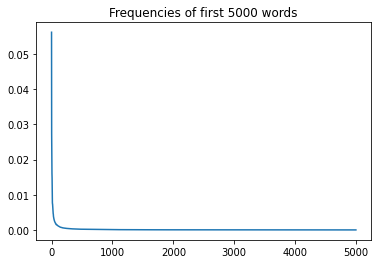

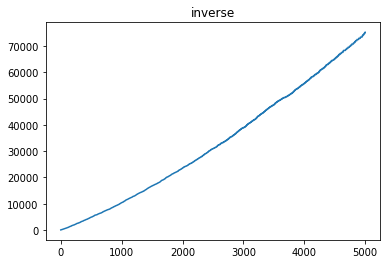

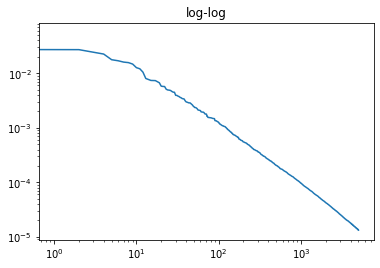

In [255]:
n = 5000
plt.title(f"Frequencies of first {n} words")
plt.plot(model_1gram.freq.values[:n])
plt.show()

plt.title("inverse")
plt.plot(1 / model_1gram.freq.values[:n])
plt.show()

plt.title("log-log")
plt.loglog(model_1gram.freq.values[:n])
plt.show()

The entire procedure is summarized as follows

In [266]:
model_3gram

count          freq
0                  1        2                        
<s>                it       s     11082  9.480760e-04
one                of       the    9819  8.400251e-04
<s>                this     is     8664  7.412137e-04
                   it       is     5913  5.058630e-04
                   if       you    5818  4.977356e-04
...                                 ...           ...
greg               mclane   give      1  8.555099e-08
                   matthews </s>      1  8.555099e-08
                   lombardo s         1  8.555099e-08
                   leaps    and       1  8.555099e-08
zzzzzzzzzzzzzzzzzz if       imdb      1  8.555099e-08

[6025088 rows x 2 columns]

In [256]:
from nltk import ngrams

def ng_tokenize(text: str, ng: int) -> list:
    """
    extract ngram and add sepcial symbols
    
    Args:
      :text:  text
      :ng:    ngram level
      
    Returns:
      list of ngrams 
    """
    tokens = re.findall(TOKEN_PATTERN, text.lower())
    ngz = ngrams(tokens, ng,
                 pad_left=True, pad_right=True,
                 left_pad_symbol=SENT_START_TOKEN,
                 right_pad_symbol=SENT_END_TOKEN)
    return list(ngz)


def build_ngram_model(text: str, ng: int) -> pd.DataFrame:
    """
    1. Clean text, 
    2. Add sentence begin and end symbols
    3. Extract ngrams
    4. Remove unwanted tokens
    5. Compute frequency of every token
    
    Returns:
      dataframe. Indexes are ngrams. Columns indiacte number of occurances 
      and frequency of occurance
    """
    print("Cleaning text...")
    text = re.sub(r"<br ?/>","", text)  # remove html tags <br /> and <br/>
    print("Extracting tokens...")
    tokens = ng_tokenize(text, ng)
    print("Removing unwanted tokens...")
    tokens = [t for t in tokens if not (('<s>' in t[1:]) or ('</s>' in t[:-1]) or (t == ("<s>", "</s>")))]
    print("Counting tokens...")
    df_ng = pd.DataFrame(pd.DataFrame(tokens).value_counts()).rename(columns = {0 : 'count'})
    print("Computing frequencies...")
    df_ng.loc[:, 'freq'] = df_ng['count'] / df_ng['count'].sum()  # compute frequencies
    return df_ng

### Bigram Model:
$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i|w_{i-1}] 
$$
(assign probability to sentences based on frequency of occurances of a word given the previous word in the sentence).


In [257]:
model_2gram = build_ngram_model(" ".join(df.review), 2)

Cleaning text...
Extracting tokens...
Removing unwanted tokens...
Counting tokens...
Computing frequencies...


In [260]:
k = 15
print(f" {k} most frequenct tokens:")
model_2gram

 15 most frequenct tokens:


count          freq
0                                            1                            
of                                           the       77220  6.283635e-03
<s>                                          the       72914  5.933242e-03
                                             i         60028  4.884668e-03
in                                           the       50258  4.089652e-03
<s>                                          it        33949  2.762537e-03
...                                                      ...           ...
help                                         although      1  8.137316e-08
                                             alicia        1  8.137316e-08
                                             aidan         1  8.137316e-08
                                             aid           1  8.137316e-08
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz </s>          1  8.137316e-08

[2109806 rows x 2 columns]

Bigrams also obey the Zipf law:

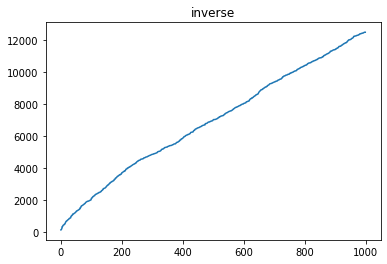

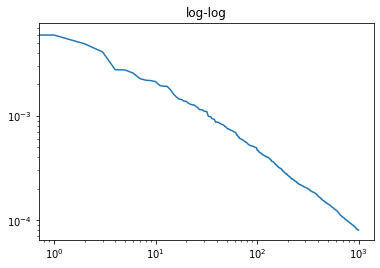

In [262]:
plt.title("inverse")
plt.plot(1 / model_2gram.freq.values[:1000])
plt.show()

plt.title("log-log")
plt.loglog(model_2gram.freq.values[:1000])
plt.show()

### Trigram Model

$$
\Pr[w_1,w_2,w_3,\ldots,w_n] = \prod_{i=1}^n \Pr[w_i|w_{i-1},w_{i-2}] 
$$


In [263]:
model_3gram = build_ngram_model(" ".join(df.review), ng=3)

Cleaning text...
Extracting tokens...
Removing unwanted tokens...
Counting tokens...
Computing frequencies...


In [264]:
k = 15
print(f"{k} most frequent 3grams:")
print(model_3gram.head(k))

15 most frequent 3grams:
                  count      freq
0    1     2                     
<s>  it    s      11082  0.000948
one  of    the     9819  0.000840
<s>  this  is      8664  0.000741
     it    is      5913  0.000506
     if    you     5818  0.000498
     this  movie   5757  0.000493
i    don   t       5415  0.000463
this movie is      5262  0.000450
of   the   film    5169  0.000442
this is    a       4810  0.000412
it   s     a       4700  0.000402
a    lot   of      4694  0.000402
this movie </s>    4468  0.000382
of   the   movie   4325  0.000370
<s>  the   film    4324  0.000370


# Sentence probability


In [268]:
class State(object):
    """
    class to manage sequential state progression
    
    Args:
        past, present, future are lists
        
    Methods:
        State::step   update one step in time, so that the present 
        is appended to the past and the present gets the next value from the future
    """
    def __init__(self, past: list, present: list, future: list):
        self.past = past
        self.present = present
        self.future = future
        
    def step(self):
        self.past += self.present
        if len(self.future) > 0:
            self.present = [self.future.pop(0)]
        else:
            self.present = []
            self.future = []
            
    def print_state(self):
        print("past:", self.past)
        print("present:", self.present)
        print("future:", self.future)


In [280]:

def token_probability(token : str, model: pd.DataFrame) -> float:
    """
    probability of a token under the model
    
    Note: gives the marginal if number of ngrams in token is smaller
    than the size of the model
    
    If token = "" then return 1
    
    """
    if len(token) == 0:  
        return 1     # we define that an empty token has probability 1
    token_idx = tuple(token)
    
    if token == '<s>':
        return 1
    
    if token_idx in model.index:
        return model.loc[token_idx].freq.sum()
    # else:     
    print(f"Unrecognized Token {token}")
    raise ValueError                
    

def conditional_probability(token_a: list, token_b: list, model: pd.DataFrame, verbose=False) -> float:
    """
    Probability of token_a given token_b under the model
    (token can contain multiple words depending on the model definition)
    """
    
    pr_b = token_probability(token_b, model)
    pr_ab = token_probability(token_b + token_a, model)
    return pr_ab / pr_b
    
    
def sentence_probability(sent: str, model: pd.DataFrame,
                         verbose=False, backoff=False) -> float:
    """
    Probability of a sentence under an n-gram languge model
    
    Args:
        :sent:    the sentence 
        :model:   the model
        :verbose: flag whther to print computing process
        :bakcoff: try backing off to handle unknown ngrams
        
    Returns:
       probability
    """
    
    ng = len(model.index[0])  # identify model order

    sent_atoms = sent.split()  
    first_token = sent_atoms[:1] 

    word_stream = State(past=[], present=first_token, future=sent_atoms[1:])

    # update state
    logprob = 0
    while len(word_stream.present) > 0:
        if backoff:
            pr_token = conditional_probability_backoff(word_stream.present,
                                                       word_stream.past[-ng+1:],
                                                       model, verbose=verbose)
        else:
            pr_token = conditional_probability(word_stream.present, word_stream.past[-ng+1:],
                                               model)
        logprob += np.log(pr_token)
        if verbose:
            word_stream.print_state()
            print(f"P(present|past) = {pr_token}")
            print("------------------------------------")
        word_stream.step()

    return np.exp(logprob)


def conditional_probability_backoff(token_a:str, token_b:str, model: pd.DataFrame, verbose=False) -> float:
    """
    same as `conditional_probability` but backs off if n-gram token_a || token_b 
    does not exists in the model 
    
     """
    
    joint_token_idx = tuple(token_b + token_a)
    
    if joint_token_idx not in model.index:
        if verbose:
            print(f"Token_a = {token_a}, Backing-off from {token_b} to {token_b[1:]}...")
        return conditional_probability_backoff(token_a, token_b[1:], model)
    else:
        return conditional_probability(token_a, token_b, model)
    return pr_ab / pr_b
    


Make sure that conditional probability behaves as expected:

In [281]:
test_tokens = ['<s>', 'on', 'of', 'there', 'movie']
for t in test_tokens:
    assert conditional_probability([t],[], model_2gram) == token_probability([t], model_2gram)

### Probability of a bigram:

In [282]:
print(conditional_probability(['of'], ['one'], model_2gram)) #* token_probability('one', model_2gram))
print(sentence_probability("one of", model_2gram))
print(sentence_probability("<s> one of </s>", model_2gram))
print(sentence_probability("<s> one of", model_2gram))
print(sentence_probability("one of </s>", model_2gram))

0.30314453671736497
0.0013218255416502392
7.921010475950982e-07
9.728991203263123e-05
1.0761849552581969e-05


Explain the differences

#### Probability of a longer sentence:

##### Bigram model:

In [283]:
# fix start token prob
print(sentence_probability("<s> what a great movie it was </s>", model_2gram, verbose=True))

past: []
present: ['<s>']
future: ['what', 'a', 'great', 'movie', 'it', 'was', '</s>']
P(present|past) = 0.04883439057405914
------------------------------------
past: ['<s>']
present: ['what']
future: ['a', 'great', 'movie', 'it', 'was', '</s>']
P(present|past) = 0.009046388359835967
------------------------------------
past: ['<s>', 'what']
present: ['a']
future: ['great', 'movie', 'it', 'was', '</s>']
P(present|past) = 0.059117428003972204
------------------------------------
past: ['<s>', 'what', 'a']
present: ['great']
future: ['movie', 'it', 'was', '</s>']
P(present|past) = 0.01866883871027684
------------------------------------
past: ['<s>', 'what', 'a', 'great']
present: ['movie']
future: ['it', 'was', '</s>']
P(present|past) = 0.04405602117335686
------------------------------------
past: ['<s>', 'what', 'a', 'great', 'movie']
present: ['it']
future: ['was', '</s>']
P(present|past) = 0.01125831580144425
------------------------------------
past: ['<s>', 'what', 'a', 'great', 

##### Trigram model

In [273]:
print(sentence_probability("<s> what a great movie it was </s>", model_3gram, verbose=True))

past: []
present: ['<s>']
future: ['what', 'a', 'great', 'movie', 'it', 'was', '</s>']
P(present|past) = 0.05134162767252725
------------------------------------
past: ['<s>']
present: ['what']
future: ['a', 'great', 'movie', 'it', 'was', '</s>']
P(present|past) = 0.009046388359835969
------------------------------------
past: ['<s>', 'what']
present: ['a']
future: ['great', 'movie', 'it', 'was', '</s>']
P(present|past) = 0.1510407073125806
------------------------------------
past: ['<s>', 'what', 'a']
present: ['great']
future: ['movie', 'it', 'was', '</s>']
P(present|past) = 0.05984251968503937
------------------------------------
past: ['<s>', 'what', 'a', 'great']
present: ['movie']
future: ['it', 'was', '</s>']
P(present|past) = 0.0975447909754479
------------------------------------
past: ['<s>', 'what', 'a', 'great', 'movie']
present: ['it']
future: ['was', '</s>']
P(present|past) = 0.02377972465581978
------------------------------------
past: ['<s>', 'what', 'a', 'great', 'mo

Trigram probability is generally higher for "natural" sentences

In [275]:
print(np.log(sentence_probability("a great action movie", model_3gram)))

-15.854701961258888


In [276]:
print(np.log(sentence_probability("a great car movie", model_3gram)))

-18.353594853021626


In [277]:
sent = "<s> a wonderful little production </s>"
print(f"2gram probability of '{sent}': p = ", sentence_probability(sent, model_2gram))
print(f"3gram probability of '{sent}': p = ", sentence_probability(sent, model_3gram))

2gram probability of '<s> a wonderful little production </s>': p =  8.746416808025598e-13
3gram probability of '<s> a wonderful little production </s>': p =  7.385032510793528e-10


In general, the 3-gram model suppose to give higher probabilities to more English looking sentences

### What kinds of knowledge we can get from a model?

In [284]:
model = model_3gram
print("actor vs. actress")
print("=================")

for w in ['good', 'great', 'talented', 'poor']:
    print(w)
    p1 = conditional_probability(['actor'], [w.lower()], model)
    p2 = conditional_probability(['actress'], [w.lower()], model)
    print("\t","actor: ", p1)
    print("\t","actress: ", p2)
    print("\t","ratio: ", p1/p2)


actor vs. actress
good
	 actor:  0.006785661602006195
	 actress:  0.0033190736096769436
	 ratio:  2.0444444444444443
great
	 actor:  0.011454619835193736
	 actress:  0.004675355034772954
	 ratio:  2.45
talented
	 actor:  0.04562043795620438
	 actress:  0.03375912408759124
	 ratio:  1.3513513513513513
poor
	 actor:  0.001956400223588597
	 actress:  0.0005589714924538849
	 ratio:  3.5


Gramer correction:

In [286]:
model = model_2gram
print(sentence_probability("one of the best action movies ever", model))
print(sentence_probability("one of the best action movie ever", model))

6.432560444406259e-12
3.83421553604735e-12


In [287]:
model = model_2gram
print(sentence_probability("talking to her", model))
print(sentence_probability("talking at her", model))

1.1032043046705936e-07
5.704782430401612e-09


Movies are more likely to be watched than read:

In [288]:
print(sentence_probability("<s> only one movie to read </s>", model_3gram))
print(sentence_probability("<s> only one movie to watch </s>", model_3gram))

5.421248159871611e-15
5.748805396404806e-12


### The method breaks when we ask for unseen ngrams:

In [289]:
print(sentence_probability("<s> a great movie to bake at home </s>", model_3gram))

Unrecognized Token ['movie', 'to', 'bake']


ValueError: 

One solution is "simple backoff":
$$
\Pr[w_i|w_{i-N+1}^{i-1}] \approx \Pr[w_i|w_{i-k+2}^{i-1}]
$$
(removing words from the tail of the conditioned sentence)

In [290]:
print(sentence_probability("<s> a great movie to bake at home </s>", model_3gram, backoff=True, verbose=True))

past: []
present: ['<s>']
future: ['a', 'great', 'movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.05134162767252725
------------------------------------
past: ['<s>']
present: ['a']
future: ['great', 'movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.016129865412269694
------------------------------------
past: ['<s>', 'a']
present: ['great']
future: ['movie', 'to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.024896694214876034
------------------------------------
past: ['<s>', 'a', 'great']
present: ['movie']
future: ['to', 'bake', 'at', 'home', '</s>']
P(present|past) = 0.0975447909754479
------------------------------------
past: ['<s>', 'a', 'great', 'movie']
present: ['to']
future: ['bake', 'at', 'home', '</s>']
P(present|past) = 0.06007509386733418
------------------------------------
Token_a = ['bake'], Backing-off from ['movie', 'to'] to ['to']...
past: ['<s>', 'a', 'great', 'movie', 'to']
present: ['bake']
future: ['at', 'home', '</s>']
P(pr

Note that with "simple backoff" we no longer have a probability distribution. 

Other techniques to handle zeros: See [Jurafsky & Martin] for details. 

## Perplexity

### Log perplexity of sequence $w^n=(w_1,\ldots,w_n)$ under model P:
$$
LLP(w^n,P) = - \frac{1}{n} \log(\Pr[w^n]) = - \frac{1}{n} \sum_{i=1}^n \log(\Pr[w_i|w^{i-1}_{i-N+1}]) 
$$

In [291]:
def perplexity(sentence: str, model: pd.DataFrame) -> float:
    """
    evalaute the perplexity of `sentence` under the model
    """
    N = len(sentence.split())
    prob = sentence_probability(sentence, model, backoff=True)
    return -np.log(prob) / N
        

Perplexity of one sentence:

In [292]:
sentences = ["<s> not as good as your average movie but still does the trick </s>",
             "<s> great do me but soon get out </s>"]

for sent in sentences:
    print("Sentence: ", sent)
    print(f"LPP of bigram model = {perplexity(sent, model_2gram)}")
    print(f"LPP of trigram model = {perplexity(sent, model_3gram)}")
    print()

Sentence:  <s> not as good as your average movie but still does the trick </s>
LPP of bigram model = 4.598590373748019
LPP of trigram model = 3.6343560644357678

Sentence:  <s> great do me but soon get out </s>
LPP of bigram model = 5.564016303930118
LPP of trigram model = 5.340172213664282



Perplexity of many sentences

In [294]:
import re

def preprocess_sentence(text: str) -> str:
    """
    clean text and add sybols indicating beginning and ending
    """
    
    n = ng
    text = re.sub(r"<br ?/>", "", text)  # remove the word '<br />' if it exists in the text
    return " ".join(re.findall(TOKEN_PATTERN, text)).lower()

def to_sentences(text: str) -> list:
    """
    Convert text after preprocessing to a list 
    of sentences
    """
    text = text.strip('<s> ').strip(' </s>')
    texts = text.split(' </s> <s> ')
    return [t.strip() for t in texts]



Average LPP of bigram model = 3.569940095527757, (std = 1.5208041197595408)


In [295]:
model = model_2gram

N = 10000
test_set = df.sample(N).review

ls = []
for doc in test_set:
    for sent in to_sentences(doc):
        lpp = perplexity(preprocess_sentence(sent), model)
        if lpp > 0:
            ls += [lpp]
print(f"Average LPP of bigram model = {np.mean(ls)}, (std = {np.std(ls)})")


RecursionError: maximum recursion depth exceeded in comparison

## Sampling from the model

In [239]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


def sample_from_model(ngram_model, prompt=['<s>']):
    
    def sample_from_list(df):
        return df.sample(n=1, weights = df.freq)
    
    w = ''
    state = prompt
    smp = sample_from_list(ngram_model.loc[state])
    state = list(smp.index[0][1:])
    w = list(state)
    while w[-1] != '</s>': 
        df_pool = ngram_model.loc[tuple(state)]
        smp = df_pool.sample(n=1, weights = df_pool.freq)
        state = state[1:] + [smp.index[0]]
        w.append(state[-1])
    return w[:-1]

In [332]:
prompt = ['<s>']
print(" ".join(prompt + sample_from_model(model_3gram, prompt=prompt)))

<s> in other films aren t even notice however that man and once we do not miss earth


# Approximating Shakespeare 

Shakespeare corpus: 

$N=899,680$ tokens, $V \approx 29,000$ 
Shakespeare produced $\approx 300,000$ bigram types out of $V^2 ~ 844 \times 10^6$ possiblee bigrams.
- 99.96% of possible bigrams were never seen (have zro entries in the table)
- Quadragrams is worse: what's coming out looks like Shakespeare because it *is* Shakespeare

In [301]:
!pwd

/Users/kipnisal/Teaching/Information Theory/ITnLM/notebooks


In [302]:
with open("../data/Shakespeare_corpus.txt", 'rt') as f:
    text = f.read()
print("Number of tokens = ", len(text.split()))

Number of tokens =  899680


In [303]:
shake_2g = build_ngram_model(break_sentence(text), 2)

Cleaning text...
Extracting tokens...
Removing unwanted tokens...
Counting tokens...
Computing frequencies...


In [307]:
prompt = ['<s>']
print(" ".join(prompt + sample_from_model(shake_2g, prompt=prompt)))

<s> so far to me that would to steal but riding to see old man to london


In [308]:
shake_4g = build_ngram_model(break_sentence(text), 4)

Cleaning text...
Extracting tokens...
Removing unwanted tokens...
Counting tokens...
Computing frequencies...


In [325]:
prompt = ['<s>']
print(" ".join(prompt + sample_from_model(shake_4g, prompt=prompt)))

<s> you bawdy but joan la pucelle join d


### Shakeseare Insult Generator

Web: https://codepo8.github.io/shakespeare-insult-generator/

Code: https://github.com/codepo8/shakespeare-insult-generator/blob/master/index.html

In [1324]:
insults = [
        ['artless','bawdy','beslubbering','bootless','churlish','cockered','clouted','craven','currish','dankish','dissembling','droning','errant','fawning','fobbing','froward','frothy','gleeking','goatish','gorbellied','impertinent','infectious','jarring','joggerheaded','lumpish','mammering','mangled','mewling','paunchy','pribbling','puking','puny','rank','reeky','roguish','ruftish','saucy','spleeny','spongy','surly','tottering','unmuzzled','vain','venomed','villainous','warped','wayward','weedy','yeasty'],
        ['base-court','bat-forling','beef-witted','beetle-headed','boil-brained','clapper-clawed','clay-brained','common-kissing','crook-pated','dismal-dreaming','dizzy-eyed','doghearted','dread-bolted','earth-vexing','elf-skinned','fat-kidneyed','fen-sucked','flap-mothed','fly-bitten','folly-fallen','fool-born','fill-gorged','guts-griping','half-faced','hasty-witted','hedge-born','hell-hated','idle-headed','ill-breeding','ill-nurtured','knotty-pated','milk-livered','motley-minded','onion-eyed','plume-plucked','pottle-deep','pox-marked','reeling-ripe','rough-hewn','rude-growing','rump-faced','shard-borne','sheep-biting','spur-galled','swag-bellied','tardy-gaited','tickle-brained','toad-spotted','unchin-snoted','weather-bitten'],
        ['apple-john','baggage','barnacle','bladder','boar-pig','bugbear','bum-bailey','canket-blossom','clack-dish','clotpole','coxcomb','codpiece','death-token','dewberry','flap-dragon','flax-wench','flirt-gill','foot-licker','futilarrian','giglet','gudgeon','haggard','harpy','hedge-pig','horn-beast','hugger-mugger','joithead','lewduster','lout','maggot-pie','malt-worm','mammet','measle','minnow','miscreant','moldwarp','mumble-news','nut-hook','pigeon-egg','pignut','puttock','pumbion','ratsbane','scut','skainsmate','strumpot','varlot','vassal','wheyface','wagtail']
      ]

In [1352]:
ww = []
for i in range(3):
    smp = insults[i][np.random.randint(len(insults[i]))]
    ww.append(smp)

f"Thou {ww[0]} {ww[1]}, {ww[2]}!"

'Thou pribbling doghearted, vassal!'

## Frequencies of English letters:

In [326]:
dff = pd.read_csv("../data/English_letter_frequency.csv")

In [327]:
dff

,letter,frequency
0,A,0.08167
1,B,0.01492
2,C,0.02782
3,D,0.04253
4,E,0.12702
5,F,0.02288
6,G,0.02015
7,H,0.06094
8,I,0.06966
9,J,0.00153


In [8]:
print(f"F0 = {np.log2(26)}")
print(f"F1 = {-np.sum(dff.frequency * np.log2(dff.frequency))}")

F0 = 4.700439718141092
F1 = 4.178175485929133


In [10]:
print(f"F1 = {-np.sum(1/26 * np.log2(dff.frequency))}")

F1 = 5.58845872439874
